# Universidade Federal do Rio Grande do Norte


## Programa de Pós-Graduação em Engenharia Elétrica e de Computação
## EEC1509 - Aprendizagem de Máquina


# Group

## João Lucas Correia Barbosa de Farias

## Júlio Freire Peixoto Gomes


# Project 1 - Red Wine Quality Classification


## About the Project
This project is divided in 8 files including this one, where each one represents one step in the process of deploying a machine learning algorithm. In this case, we choose a Decision Tree algorithm as Classifier due to its simplicity and because it is the algorithm we saw in class. However, other classifiers may perform a better fit.

The dataset has some characteristics about red wines and their quality based on that information, so our mission is to predict the quality of any red wine using the same information we used to train our model.


### The details about the dataset are shown below.

For more information, read [Cortez et al., 2009].

### Input variables (based on physicochemical tests):


1. fixed acidity

2. volatile acidity

3. citric acid

4. residual sugar

5. chlorides

6. free sulfur dioxide

7. total sulfur dioxide

8. density

9. pH

10. sulphates

11. alcohol

Output variable (based on sensory data):

12. quality (score between 0 and 10)

## The dataset was taken from Kaggle:
https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009

# 1.0 Install and Load Libraries


In [1]:
# install wandb
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 27.4 MB/s 
     |████████████████████████████████| 145 kB 44.5 MB/s 
     |████████████████████████████████| 181 kB 44.8 MB/s 
     |████████████████████████████████| 63 kB 842 kB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=42df597e117bcc8c03556ddb0b51f112c1694557710c4aa3b82f9c0474e5a1e4
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
import logging
import pandas as pd
import wandb
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.metrics import geometric_mean_score
import matplotlib.pyplot as plt

# 2.0 Test
In this last step, we will test the exported model against the test set and analyze the results.

## 2.1 Login to Weights & Biases

In [3]:
# login to wandb
!wandb login --relogin

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## 2.2 Classes Used in Pipeline

It is necessary to define (again) the classes used in the pipeline creation so that joblib can work properly.

In [4]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # constructor of the classs
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.feature_names]


class NumericalTransformer(BaseEstimator, TransformerMixin):
    # model 0: minmax
    # model 1: standard
    # model 2: no scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # fit function is responsible for learning statistical data about features
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # function to retrieve columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # transforming numerical features
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # update columns name
        self.colnames = df.columns.tolist()

        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df

## 2.3 Importing Model and Target Encoder

In [5]:
# name of the artifact related to test dataset
artifact_test_name = "red_wine_quality/test.csv:latest"

# name of the model artifact
artifact_model_name = "red_wine_quality/model_export:latest"

# name of the target encoder artifact
artifact_encoder_name = "red_wine_quality/target_encoder:latest"

In [6]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

In [7]:
# initiate the wandb project
run = wandb.init(project="red_wine_quality",job_type="test")

wandb: Currently logged in as: jotafarias (ppgeec-ml-jj). Use `wandb login --relogin` to force relogin


In [8]:
logger.info("Downloading and reading test artifact...")
test_data_path = run.use_artifact(artifact_test_name).file()
df_test = pd.read_csv(test_data_path)

# Extract the target from the features
logger.info("Extracting target from dataframe...")
x_test = df_test.copy()
y_test = x_test.pop("quality")

29-05-2022 19:23:37 Downloading and reading test artifact...
29-05-2022 19:23:38 Extracting target from dataframe...


In [9]:
# checking the dataset to see if everything is ok
x_test.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
0,7.2,0.480,0.07,5.5,0.089,10.0,18.0,0.99684,3.37,0.68,11.2
1,8.0,0.810,0.25,3.4,0.076,34.0,85.0,0.99668,3.19,0.42,9.2
2,10.6,0.310,0.49,2.5,0.067,6.0,21.0,0.99870,3.26,0.86,10.7
3,9.5,0.885,0.27,2.3,0.084,31.0,145.0,0.99780,3.24,0.53,9.4
4,6.6,0.580,0.02,2.4,0.069,19.0,40.0,0.99387,3.38,0.66,12.6


In [10]:
x_test.shape

(408, 11)

In [11]:
# checking the dataset to see if everything is ok
y_test.head()

0    good
1     bad
2     bad
3     bad
4     bad
Name: quality, dtype: object

In [12]:
y_test.shape

(408,)

In [13]:
# extracting the encoding of the target variable using joblib
logger.info("Extracting the encoding of the target variable...")
encoder_export_path = run.use_artifact(artifact_encoder_name).file()
le = joblib.load(encoder_export_path)

29-05-2022 19:24:02 Extracting the encoding of the target variable...


In [14]:
# transforming y_test
y_test = le.transform(y_test)
logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

29-05-2022 19:24:15 Classes [0, 1]: ['bad' 'good']


In [15]:
# target variable after the encoding
y_test

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [16]:
# downloading inference artifact using joblib
logger.info("Downloading and load the exported model")
model_export_path = run.use_artifact(artifact_model_name).file()
pipe = joblib.load(model_export_path)

29-05-2022 19:25:53 Downloading and load the exported model


## 2.4 Prediction and Evaluation of Test Set

In [17]:
# predicting the rating of the test set
logger.info("Infering...")
predict = pipe.predict(x_test)

# Evaluation Metrics
logger.info("Test Evaluation Metrics:")
fbeta = fbeta_score(y_test, predict, beta=1, zero_division=1)
precision = precision_score(y_test, predict, zero_division=1)
recall = recall_score(y_test, predict, zero_division=1)
acc = accuracy_score(y_test, predict)

logger.info("Test Accuracy: {}".format(acc))
logger.info("Test Precision: {}".format(precision))
logger.info("Test Recall: {}".format(recall))
logger.info("Test F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

29-05-2022 19:26:47 Infering...
29-05-2022 19:26:47 Test Evaluation Metrics:
29-05-2022 19:26:47 Test Accuracy: 0.8382352941176471
29-05-2022 19:26:47 Test Precision: 0.3829787234042553
29-05-2022 19:26:47 Test Recall: 0.32727272727272727
29-05-2022 19:26:47 Test F1: 0.35294117647058826


In [18]:
# comparing the accuracy, precision, recall with previous ones
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       353
           1       0.38      0.33      0.35        55

    accuracy                           0.84       408
   macro avg       0.64      0.62      0.63       408
weighted avg       0.83      0.84      0.83       408



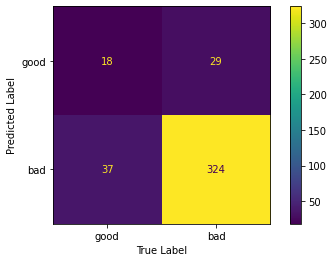

In [19]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_test,labels=[1,0]),
                       display_labels=["good","bad"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [20]:
# uploading figures
logger.info("Uploading figures...")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
    }
)

29-05-2022 19:27:45 Uploading figures...


In [21]:
run.finish()

Acc,0.83824
F1,0.35294
Precision,0.38298
Recall,0.32727
